# 🖍️ Drawing with LLMs: Fine-Tuning Qwen3-4B using Unsloth

Welcome to this notebook for the [Drawing with LLMs](https://www.kaggle.com/competitions/drawing-with-llms) competition! Here we aim to train a large language model capable of producing **SVG code** from natural language prompts. This notebook demonstrates how to **fine-tune Qwen3-4B model** using the [Unsloth](https://github.com/unslothai/unsloth) library!

The primary objective is to teach the model to generate **high-quality SVG image code** that matches a given textual description. 

In [2]:
%%capture
!pip install pip3-autoremove
# !pip-autoremove torch torchvision torchaudio -y
!pip install torch torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu121
!pip install unsloth

## Load the model using Unsloth

In [3]:
from unsloth import FastLanguageModel
import torch
import kagglehub
import pandas as pd

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

######---Parameters to change---#######
dtype = ( None )
load_in_4bit = False
load_in_8bit = False
max_seq_length = 2048
Rank=128
max_iter_steps=300
###--------------------------------###
model_name = kagglehub.model_download("qwen-lm/qwen-3/transformers/4b")
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_name,
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
    load_in_8bit=load_in_8bit
)

print(model.dtype)       # torch.float16
print(model.device)      # cuda:0

print(type(model))       # <class 'transformers.models.qwen3.modeling_qwen3.Qwen3ForCausalLM'>

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-05-19 04:54:00.211573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747630440.651742      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747630440.779030      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.5.6: Fast Qwen3 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

torch.float16
cuda:0
<class 'transformers.models.qwen3.modeling_qwen3.Qwen3ForCausalLM'>


## Define LoRA Settings

In [7]:
model = FastLanguageModel.get_peft_model(
    model,
    r = Rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 123,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.5.6 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


## Get training data from the link [svg-generation-sample-training-data](https://www.kaggle.com/datasets/vinothkumarsekar89/svg-generation-sample-training-data)

In [8]:
train_data_path= kagglehub.dataset_download('vinothkumarsekar89/svg-generation-sample-training-data')
df_train = pd.read_csv('/kaggle/input/svg-generation-sample-training-data/train_data_svg_generation_sample.csv')
print(df_train.shape)
df_train.head(2)

(1002, 2)


,description,svg
0,"'Golden wheat fields under a setting sun',","<svg viewBox=""0 0 200 200"" width=""200"" height=..."
1,"'Snowy mountains under a clear blue sky',","<svg viewBox=""0 0 200 100"" width=""200"" height=..."


In [9]:
print(df_train['description'].loc[0])
print(df_train['description'].loc[1])
print(df_train['description'].loc[2])
print(df_train['description'].loc[3])
print(type(df_train['description'].loc[3]))

des_list = list()

for i in range(10,20):
    des_list.append(df_train['description'].loc[i])

'Golden wheat fields under a setting sun',
 'Snowy mountains under a clear blue sky',
 'Checkerboard pattern with alternating green and black squares',
 'Crimson and gold spirals intertwining',
<class 'str'>


Prompt:  'Golden wheat fields under a setting sun',
thinking content: 
 <think>
Okay, the user wants me to generate SVG code for the description "Golden wheat fields under a setting sun". Let me start by breaking down the elements mentioned here.

First, the main subjects are wheat fields and a setting sun. The color golden suggests warm tones, maybe yellows and oranges. The setting sun implies a sunset, so I should think about the colors of the sky during that time—perhaps pink, orange, and purple hues.

I need to create a landscape. In SVG, I can use rectangles for the sky and the fields. The wheat fields could be represented with a gradient from golden yellow to a lighter shade. The sun might be a circle with a gradient to simulate the setting sun effect.

I should consider the layers. The sky at the top, then the wheat fields in the middle, and maybe some clouds to add realism. The sun would be positioned in the upper right corner to indicate it's setting.

Gradients are essential 

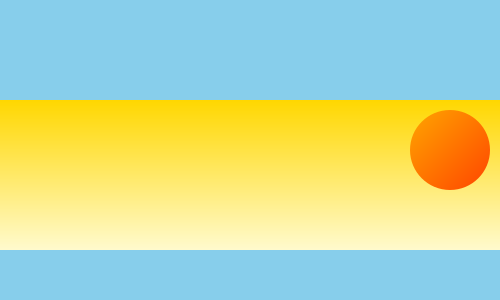

"'Golden wheat fields under a setting sun',"

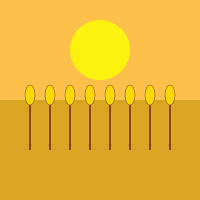

"'Golden wheat fields under a setting sun',"


CPU times: user 44.5 s, sys: 510 ms, total: 45 s
Wall time: 46.8 s


In [10]:
%%time

from IPython.display import SVG, display

def show_svg(svg_code: str, text: str = ""):
    display(SVG(svg_code))
    if text:
        display(text)
        
sys_prompt = """You are a SVG Image code generator and you only generate code without comments  and other messages, nothing else.

The descriptions are of common, generic subjects. No brand name or trademark or personal name occurs in any description. No people, even in generic form, occur in any description.
The subjects described span about a dozen categories. Three of these categories, landscapes, abstract, and fashion.
No description has more than 200 characters. The average length is around 50 characters.

Generate the code for provided description."""

def gen(idx, thinking_mode=False):

    prompt, original_svg_code = str(df_train['description'].loc[idx]),str(df_train['svg'].loc[idx])
    # prompt = str(prompt)
    # prepare the model input
    messages = [
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=thinking_mode # Switches between thinking and non-thinking modes. Default is True.
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    
    # conduct text completion
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=32768
    )
    output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist() 
    
    # parsing thinking content
    try:
        # rindex finding 151668 ()
        index = len(output_ids) - output_ids[::-1].index(151668)
    except ValueError:
        index = 0
    
    thinking_content = tokenizer.decode(output_ids[:index], skip_special_tokens=True).strip("\n")
    content = tokenizer.decode(output_ids[index:], skip_special_tokens=True).strip("\n")
    
    # print("thinking content:", thinking_content)
    print("Prompt: ",prompt)
    print("thinking content: \n",thinking_content)
    print("content: \n",content);print();print()
    
    show_svg(content,prompt); print()
    # show_svg(thinking_content, prompt);print()
    show_svg(original_svg_code, prompt); print()
    
    return content

r0 = gen(0,True)

# 8.2 s -> Not thinking
# 1min 11s -> With thinking

Prompt:   'Snowy mountains under a clear blue sky',
thinking content: 
 
content: 
 <svg width="200" height="200" viewBox="0 0 200 200" xmlns="http://www.w3.org/2000/svg">
  <rect width="200" height="200" fill="skyblue"/>
  <polygon points="50,150 150,150 100,50" fill="white"/>
  <circle cx="100" cy="100" r="30" fill="snow"/>
</svg>




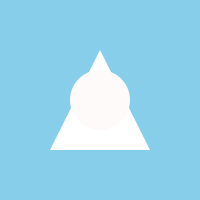

" 'Snowy mountains under a clear blue sky',"

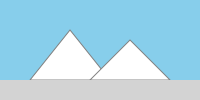

" 'Snowy mountains under a clear blue sky',"


Prompt:   'Checkerboard pattern with alternating green and black squares',
thinking content: 
 
content: 
 <svg width="200" height="200" xmlns="http://www.w3.org/2000/svg">
  <rect width="100%" height="100%" fill="black" />
  <rect width="100%" height="100%" fill="green" />
  <pattern id="checker" width="20" height="20" patternUnits="userSpaceOnUse">
    <rect width="10" height="10" fill="black" />
    <rect x="10" y="10" width="10" height="10" fill="green" />
  </pattern>
  <rect width="100%" height="100%" fill="url(#checker)" />
</svg>




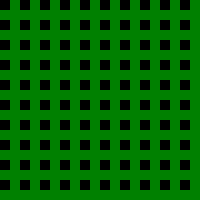

" 'Checkerboard pattern with alternating green and black squares',"

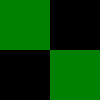

" 'Checkerboard pattern with alternating green and black squares',"

In [11]:
r1 = gen(1)
r2 = gen(2)

Prompt:   'Crimson and gold spirals intertwining',
thinking content: 
 
content: 
 <svg width="200" height="200" viewBox="0 0 200 200" xmlns="http://www.w3.org/2000/svg">
  <g fill="crimson" stroke="gold" stroke-width="2">
    <path d="M100,50 A100,100 0 1,1 150,150" />
    <path d="M150,150 A100,100 0 1,1 100,50" />
  </g>
</svg>




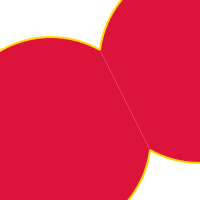

" 'Crimson and gold spirals intertwining',"

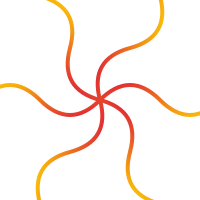

" 'Crimson and gold spirals intertwining',"

In [12]:
r3 = gen(3)

In [13]:
type(des_list[0])

str

## Prepare the data into dataset format

In [14]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}
"""

EOS_TOKEN = tokenizer.eos_token  # Must add EOS_TOKEN

def formatting_prompts_func(examples):
    topics = examples["description"]  # Using 'topic' as instruction
    svgs = examples["svg"]  # Using 'svg_code' as output
    texts = []

    
    for topic, svg_code in zip(topics, svgs):
        # No additional input is needed, so we pass an empty string
        text = alpaca_prompt.format(f"Generate a SVG code for the given input:",topic,svg_code) + EOS_TOKEN
        texts.append(text)
       
    return { "text": texts }

from datasets import Dataset
import pandas as pd
# Convert DataFrame to Hugging Face Dataset
dataset_train = Dataset.from_pandas(df_train)
dataset_train = dataset_train.map(formatting_prompts_func, batched=True)

#dataset_test = Dataset.from_pandas(df_test)
#dataset_test = dataset_test.map(formatting_prompts_func, batched=True)

Map:   0%|          | 0/1002 [00:00<?, ? examples/s]

In [15]:
print(EOS_TOKEN)

<|im_end|>


In [16]:
dataset_train

Dataset({
    features: ['description', 'svg', 'text'],
    num_rows: 1002
})

In [17]:
print(dataset_train['description'][0])
print(dataset_train['svg'][0])

'Golden wheat fields under a setting sun',
<svg viewBox="0 0 200 200" width="200" height="200" xmlns="http://www.w3.org/2000/svg">
  <!-- Background for the sky -->
  <rect x="0" y="0" width="200" height="100" fill="orange" opacity="0.7"/>
  
  <!-- Sun -->
  <circle cx="100" cy="50" r="30" fill="yellow" opacity="0.8"/>
  
  <!-- Wheat fields -->
  <rect x="0" y="100" width="200" height="100" fill="goldenrod"/>
  
  <!-- Wheat stalks -->
  <g stroke="saddlebrown" stroke-width="2">
    <line x1="30" y1="100" x2="30" y2="150"/>
    <line x1="50" y1="100" x2="50" y2="150"/>
    <line x1="70" y1="100" x2="70" y2="150"/>
    <line x1="90" y1="100" x2="90" y2="150"/>
    <line x1="110" y1="100" x2="110" y2="150"/>
    <line x1="130" y1="100" x2="130" y2="150"/>
    <line x1="150" y1="100" x2="150" y2="150"/>
    <line x1="170" y1="100" x2="170" y2="150"/>
  </g>
  
  <!-- Wheat heads -->
  <g fill="gold" stroke="saddlebrown" stroke-width="0.5">
    <ellipse cx="30" cy="95" rx="5" ry="10"/>
 

In [18]:
# Check dataset sample output
dataset_train['text'][0]

'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nGenerate a SVG code for the given input:\n\n### Input:\n\'Golden wheat fields under a setting sun\',\n\n### Response:\n<svg viewBox="0 0 200 200" width="200" height="200" xmlns="http://www.w3.org/2000/svg">\n  <!-- Background for the sky -->\n  <rect x="0" y="0" width="200" height="100" fill="orange" opacity="0.7"/>\n  \n  <!-- Sun -->\n  <circle cx="100" cy="50" r="30" fill="yellow" opacity="0.8"/>\n  \n  <!-- Wheat fields -->\n  <rect x="0" y="100" width="200" height="100" fill="goldenrod"/>\n  \n  <!-- Wheat stalks -->\n  <g stroke="saddlebrown" stroke-width="2">\n    <line x1="30" y1="100" x2="30" y2="150"/>\n    <line x1="50" y1="100" x2="50" y2="150"/>\n    <line x1="70" y1="100" x2="70" y2="150"/>\n    <line x1="90" y1="100" x2="90" y2="150"/>\n    <line x1="110" y1="100" x2="110" y2="150"/>\n    <line

## SFT trainer Settings

In [20]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset_train,
    #eval_dataset = dataset_test,  # Add test dataset here
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 3, 
        max_steps = max_iter_steps,
        learning_rate = 5e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 10,
        optim = "adamw_8bit", # "adamw_torch" better for fp16
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 123,
        #eval_strategy = "steps", 
        #eval_steps = 100, 
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

#  Unsloth: Tokenizing ["text"] (num_proc=2): 100%

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/1002 [00:00<?, ? examples/s]

## Finetune the model

In [21]:
%%time

trainer.train()
# Wall time: 1h 58min 42s

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,002 | Num Epochs = 5 | Total steps = 300
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 264,241,152/4,286,709,248 (6.16% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,0.463100
20,0.260200
30,0.216100
40,0.196100
50,0.189100
60,0.182700
70,0.180800
80,0.154500
90,0.152700
100,0.138500


CPU times: user 1h 19min 34s, sys: 39min 6s, total: 1h 58min 40s
Wall time: 1h 58min 42s


TrainOutput(global_step=300, training_loss=0.13005348453919094, metrics={'train_runtime': 7120.5285, 'train_samples_per_second': 0.674, 'train_steps_per_second': 0.042, 'total_flos': 9.811926103711334e+16, 'train_loss': 0.13005348453919094})

## Merge LoRA and save the full model in FP16 format (vLLM-compatible) 

In [22]:
#save merged 16bit
import os
dir_path = "Qwen3-4B-LoRA-SVG-Generation"
os.makedirs(dir_path, exist_ok=True)
model.save_pretrained_merged(dir_path, tokenizer, save_method = "merged_16bit")

Unsloth: You have 2 CPUs. Using `safe_serialization` is 10x slower.
We shall switch to Pytorch saving, which might take 3 minutes and not 30 minutes.
To force `safe_serialization`, set it to `None` instead.
Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 16.99 out of 31.35 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


 22%|██▏       | 8/36 [00:00<00:01, 23.66it/s]
We will save to Disk and not RAM now.
100%|██████████| 36/36 [00:12<00:00,  2.97it/s]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving Qwen3-4B-LoRA-SVG-Generation/pytorch_model-00001-of-00002.bin...
Unsloth: Saving Qwen3-4B-LoRA-SVG-Generation/pytorch_model-00002-of-00002.bin...
Done.


## Upload the model to kagglehub(use your own model handle under your username.!)

In [23]:
# # You may need this login if you want to upload model to kagglehub from local machine.
# kagglehub.login()

In [29]:
import os
for dirname, _, filenames in os.walk('/kaggle/working/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/working/outputs/checkpoint-300/rng_state.pth
/kaggle/working/outputs/checkpoint-300/adapter_model.safetensors
/kaggle/working/outputs/checkpoint-300/trainer_state.json
/kaggle/working/outputs/checkpoint-300/README.md
/kaggle/working/outputs/checkpoint-300/tokenizer.json
/kaggle/working/outputs/checkpoint-300/tokenizer_config.json
/kaggle/working/outputs/checkpoint-300/scheduler.pt
/kaggle/working/outputs/checkpoint-300/merges.txt
/kaggle/working/outputs/checkpoint-300/optimizer.pt
/kaggle/working/outputs/checkpoint-300/adapter_config.json
/kaggle/working/outputs/checkpoint-300/scaler.pt
/kaggle/working/outputs/checkpoint-300/training_args.bin
/kaggle/working/outputs/checkpoint-300/added_tokens.json
/kaggle/working/outputs/checkpoint-300/vocab.json
/kaggle/working/outputs/checkpoint-300/special_tokens_map.json
/kaggle/working/Qwen3-4B-LoRA-SVG-Generation/config.json
/kaggle/working/Qwen3-4B-LoRA-SVG-Generation/pytorch_model-00001-of-00002.bin
/kaggle/working/Qwen3-4B-LoRA-SVG-Ge

In [31]:
# Replace with path to directory containing model files.
LOCAL_MODEL_DIR = "/kaggle/working/Qwen3-4B-LoRA-SVG-Generation"

MODEL_SLUG = 'qwen3_4b_svg_code_generation' # Replace with model slug.

# Learn more about naming model variations at
# https://www.kaggle.com/docs/models#name-model.
VARIATION_SLUG = '01' # Replace with variation slug.

kagglehub.model_upload(
  handle = f"hritwijkamble/{MODEL_SLUG}/transformers/{VARIATION_SLUG}",
  local_model_dir = LOCAL_MODEL_DIR,
  version_notes = 'Update 2025-05-05')

Uploading Model https://www.kaggle.com/models/hritwijkamble/qwen3_4b_svg_code_generation/transformers/01 ...
Model 'qwen3_4b_svg_code_generation' does not exist or access is forbidden for user 'hritwijkamble'. Creating or handling Model...
Model 'qwen3_4b_svg_code_generation' Created.
Starting upload for file /kaggle/working/Qwen3-4B-LoRA-SVG-Generation/config.json


Uploading: 100%|██████████| 785/785 [00:00<00:00, 1.32kB/s]

Upload successful: /kaggle/working/Qwen3-4B-LoRA-SVG-Generation/config.json (785B)
Starting upload for file /kaggle/working/Qwen3-4B-LoRA-SVG-Generation/pytorch_model-00001-of-00002.bin



Uploading: 100%|██████████| 4.97G/4.97G [00:34<00:00, 143MB/s] 

Upload successful: /kaggle/working/Qwen3-4B-LoRA-SVG-Generation/pytorch_model-00001-of-00002.bin (5GB)
Starting upload for file /kaggle/working/Qwen3-4B-LoRA-SVG-Generation/tokenizer.json



Uploading: 100%|██████████| 11.4M/11.4M [00:00<00:00, 22.4MB/s]

Upload successful: /kaggle/working/Qwen3-4B-LoRA-SVG-Generation/tokenizer.json (11MB)
Starting upload for file /kaggle/working/Qwen3-4B-LoRA-SVG-Generation/tokenizer_config.json



Uploading: 100%|██████████| 9.73k/9.73k [00:00<00:00, 25.4kB/s]

Upload successful: /kaggle/working/Qwen3-4B-LoRA-SVG-Generation/tokenizer_config.json (10KB)
Starting upload for file /kaggle/working/Qwen3-4B-LoRA-SVG-Generation/merges.txt



Uploading: 100%|██████████| 1.67M/1.67M [00:00<00:00, 4.62MB/s]

Upload successful: /kaggle/working/Qwen3-4B-LoRA-SVG-Generation/merges.txt (2MB)
Starting upload for file /kaggle/working/Qwen3-4B-LoRA-SVG-Generation/pytorch_model-00002-of-00002.bin



Uploading: 100%|██████████| 3.08G/3.08G [00:23<00:00, 132MB/s] 

Upload successful: /kaggle/working/Qwen3-4B-LoRA-SVG-Generation/pytorch_model-00002-of-00002.bin (3GB)
Starting upload for file /kaggle/working/Qwen3-4B-LoRA-SVG-Generation/pytorch_model.bin.index.json



Uploading: 100%|██████████| 32.8k/32.8k [00:00<00:00, 95.7kB/s]

Upload successful: /kaggle/working/Qwen3-4B-LoRA-SVG-Generation/pytorch_model.bin.index.json (32KB)
Starting upload for file /kaggle/working/Qwen3-4B-LoRA-SVG-Generation/added_tokens.json



Uploading: 100%|██████████| 707/707 [00:00<00:00, 1.36kB/s]

Upload successful: /kaggle/working/Qwen3-4B-LoRA-SVG-Generation/added_tokens.json (707B)
Starting upload for file /kaggle/working/Qwen3-4B-LoRA-SVG-Generation/vocab.json



Uploading: 100%|██████████| 2.78M/2.78M [00:00<00:00, 4.88MB/s]

Upload successful: /kaggle/working/Qwen3-4B-LoRA-SVG-Generation/vocab.json (3MB)
Starting upload for file /kaggle/working/Qwen3-4B-LoRA-SVG-Generation/special_tokens_map.json



Uploading: 100%|██████████| 613/613 [00:00<00:00, 1.74kB/s]

Upload successful: /kaggle/working/Qwen3-4B-LoRA-SVG-Generation/special_tokens_map.json (613B)
Starting upload for file /kaggle/working/Qwen3-4B-LoRA-SVG-Generation/generation_config.json



Uploading: 100%|██████████| 237/237 [00:00<00:00, 661B/s]

Upload successful: /kaggle/working/Qwen3-4B-LoRA-SVG-Generation/generation_config.json (237B)


Your model instance has been created.
Files are being processed...
See at: https://www.kaggle.com/models/hritwijkamble/qwen3_4b_svg_code_generation/transformers/01


In [32]:
print('Done.!')

Done.!
